In [1]:
import pandas as pd
import numpy as np
import os
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import Sequence


In [2]:
# Cargar CSV
df = pd.read_csv("/content/drive/MyDrive/Procesamiento Imagenes/Taller_5_Realizar un modelo de deteccion de boundboxes/Airplanes.csv")
df.head()

,Unnamed: 0,Image,x_top,y_top,x_bottom,y_bottom,label
0,0,image_0001.jpg,30,137,49,349,Airplanes
1,0,image_0002.jpg,35,153,59,342,Airplanes
2,0,image_0003.jpg,36,135,47,331,Airplanes
3,0,image_0004.jpg,24,141,47,342,Airplanes
4,0,image_0005.jpg,18,146,48,339,Airplanes


In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

class BoundingBoxDataset(Sequence):
    def __init__(self, dataframe, image_dir, batch_size, img_size):
        self.df = dataframe
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.indexes = np.arange(len(dataframe))

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indexes]

        batch_images = []
        batch_labels = []

        for _, row in batch_df.iterrows():
            img_path = os.path.join(self.image_dir, row["Image"])
            image = Image.open(img_path).convert("RGB").resize(self.img_size)
            w, h = image.size
            image_array = np.array(image) / 255.0

            x1, y1 = row["x_top"] / w, row["y_top"] / h
            x2, y2 = row["x_bottom"] / w, row["y_bottom"] / h
            label = [x1, y1, x2, y2]

            batch_images.append(image_array)
            batch_labels.append(label)

        return np.array(batch_images), np.array(batch_labels)


In [4]:
def create_model(input_shape):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape + (3,),
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )

    x = base_model.output
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(4, activation='sigmoid')(x)  # [x1, y1, x2, y2]

    return models.Model(inputs=base_model.input, outputs=outputs)

model = create_model(IMG_SIZE)
model.compile(optimizer=Adam(1e-4), loss=MeanSquaredError())
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 2,388,356 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [6]:
dataset = BoundingBoxDataset(df, "/content/drive/MyDrive/Procesamiento Imagenes/Taller_5_Realizar un modelo de deteccion de boundboxes/airplanes", BATCH_SIZE, IMG_SIZE)
history = model.fit(dataset, epochs=10)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 61s 254ms/step - loss: 0.2194
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 314ms/step - loss: 0.0833
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - loss: 0.0793
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 283ms/step - loss: 0.0770
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 273ms/step - loss: 0.0777
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step - loss: 0.0759
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 259ms/step - loss: 0.0759
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - loss: 0.0767
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 266ms/step - loss: 0.0769
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - loss: 0.0776


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


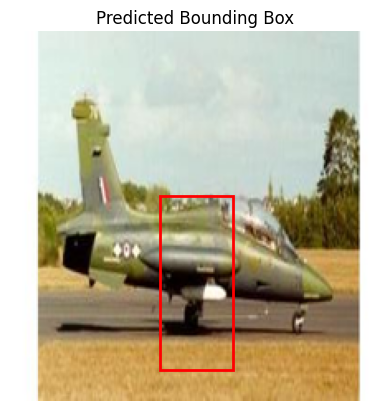

In [7]:
def plot_prediction(model, img_path):
    image = Image.open(img_path).convert("RGB").resize(IMG_SIZE)
    img_array = np.array(image) / 255.0
    pred = model.predict(np.expand_dims(img_array, axis=0))[0]

    x1, y1, x2, y2 = pred
    w, h = IMG_SIZE
    x1, y1, x2, y2 = x1 * w, y1 * h, x2 * w, y2 * h

    plt.imshow(image)
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                      edgecolor='red', facecolor='none', linewidth=2))
    plt.title("Predicted Bounding Box")
    plt.axis('off')
    plt.show()

# Probar con una imagen del dataset
plot_prediction(model, "/content/drive/MyDrive/Procesamiento Imagenes/Taller_5_Realizar un modelo de deteccion de boundboxes/airplanes/image_0001.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


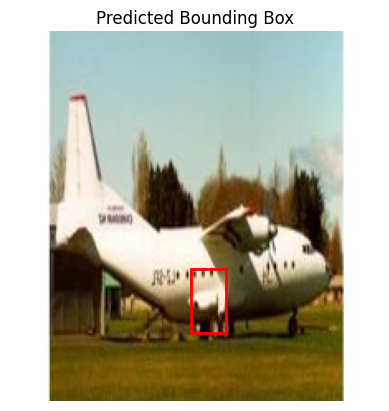

In [12]:
plot_prediction(model, "/content/drive/MyDrive/Procesamiento Imagenes/Taller_5_Realizar un modelo de deteccion de boundboxes/airplanes/image_0006.jpg")